# Data Details

https://www.kaggle.com/datasets/justin2028/political-polarization-in-us-congress

Tracks polarization data about US Congress (1879-2021) from Voteview


https://voteview.com/static/data/out/members/HSall_members.csv 

52,540 DAYS (March 4th, 1879 to January 7th, 2023)

This is a dataset that tracks political polarization in US Congress (46th to 117th) through proportions from 1879 to 2023.

All data are official figures from Voteview. Ideological positions are calculated using the DW-NOMINATE (Dynamic Weighted NOMINAl Three-step Estimation). This procedure was developed by Keith T. Poole and Howard Rosenthal in the 1980s and is a "scaling procedure", representing legislators on a spatial map. In this sense, a spatial map is much like a road map--the closeness of two legislators on the map shows how similar their voting records are. Using this measure of distance, DW-NOMINATE is able to recover the "dimensions" that inform congressional voting behavior.

*Data Sources*
The primary data source used was Voteview's official website, which publishes ideological data pertaining to America. 
Voteview's Realtime NOMINATE Ideology and Related Data 
- Voteview's download links for NOMINATE scores, tutorials for generating ancillary data, and other publicly available databases are stored here.
- Voteview's "Polarization in Congress" Data Analysis - Jeff Lewis, the project lead of Voteview, published a data analysis of the available polarization data. The detailed work gave insight into the true analytical potential of the dataset, and inspired many elements of my accompanying notebook.
- Voteview's "The Polarization of the Congressional Parties" - Voteview released a detailed overview of their polarization data, the methodology behind their data, and the proper definitions and terminologies for the variables tracked. The guide mainly provided essential contextual knowledge needed to create a meaningful dataset.

- congress: The number of the Congress in which the legislator served.
- chamber: The chamber of Congress in which the legislator served (e.g. House or Senate).
- icpsr: An identification number for the legislator based on data from the Inter-university Consortium for - Political and Social Research.
- state_icpsr: An identification number for the state in which the legislator served.
- district_code: A code indicating the district in which the legislator served (if applicable).
- state_abbrev: The two-letter abbreviation for the state in which the legislator served.
- party_code: A numerical code indicating the party affiliation of the legislator.
- occupancy: A code indicating the status of the seat the legislator held (e.g. filled or vacant).
- last_means: The method by which the legislator left office (e.g. defeated, resigned, etc.).
- bioname: The name of the legislator.
- bioguide_id: An identification number for the legislator based on data from the Biographical Directory of the United States Congress.
- born: The year of the legislator's birth.
- died: The year of the legislator's death (if applicable).
- nominate_dim1: A measure of the legislator's ideology based on their voting record.
- nominate_dim2: A second measure of the legislator's ideology based on their voting record.
- nominate_log_likelihood: A measure of the accuracy of the nominate scores.
- nominate_geo_mean_probability: A measure of the reliability of the nominate scores.
- nominate_number_of_votes: The number of roll call votes used to calculate the nominate scores.
- nominate_number_of_errors: The number of errors in the nominate scores.
- conditional: A code indicating whether the nominate scores are conditional on party membership.
- nokken_poole_dim1: An alternative measure of the legislator's ideology based on their roll call votes.
- nokken_poole_dim2: A second alternative measure of the legislator's ideology based on their roll call votes.

# Conclusions

Fields state_icpsr, district_code, and state_abbrev are correlated.
All columns starting with nominate have same number of null values.

# Read Data

In [17]:
import numpy as np
import pandas as pd
import glob
import os
import math
from IPython.display import display_html, Markdown, display
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
pathvals = ['/kaggle/input/political-polarization-in-us-congress', './input']
fnames = ['US History All House and Senate Members.csv']

path_str = ''
for pathval in pathvals:
    if os.path.exists(pathval):
        path_str = pathval
        break
        
df = pd.read_csv(os.path.join(path_str, 'US History All House and Senate Members.csv'))

# EDA Functions

In [19]:
def header_comment(msg):
    display(Markdown('**' + msg.upper() + '**'))
    display('-' * 50)
    
def basic_df_info(df):
    ''' df.info() provides information about the dimensions, column names, data types, 
        and non-null values of the dataframe in a concise format.
        df.isnull().sum() provides the count of missing values in each column of the dataframe.
        df.head() displays the first 5 rows.
    '''
    
    header_comment('BASIC INFORMATION FOR DATAFRAME')
    print(df.columns)
    print(df.info())    
    display(df.head())
    
def display_nonnull_info(df):
    header_comment('NONNULL DATA INFORMATION - BASIC')
    if df.isnull().any().any():
        null_counts = df.isnull().sum()
        nonzero_null_counts = null_counts[null_counts > 0]
        nonzero_null_cols = list(nonzero_null_counts.index)
        df[nonzero_null_cols].info(show_counts=True)

def display_null_info(df):
    header_comment('NULL DATA INFORMATION - BASIC')
    if df.isnull().any().any():
        null_counts = df.isnull().sum()
        nonzero_null_counts = null_counts[null_counts > 0]
        print(nonzero_null_counts)
        
def display_null_info_detailed(df):
    ''' Shows Null count for columns which have nonzero null values 
        Shows percentage of null values as also the column datatype 
    '''
    null_counts = df.isnull().sum()
    nonzero_null_counts = null_counts[null_counts > 0]

    nonzero_null_cols = list(nonzero_null_counts.index)
    dtypes = df.dtypes[nonzero_null_cols]

    df_null_info = pd.concat([nonzero_null_counts, dtypes], axis=1)
    df_null_info.columns = ['Null Count', 'Data Type']
    df_null_info['Percentage'] = round(df_null_info['Null Count'] / len(df) * 100, 2)

    print(df_null_info)

# EDA Functions - Detailed Column Information

In [20]:
def display_columns_info(category, ls, additional=None):
    if additional is None:
        print(category, len(ls), ls)
    else:
        print(category, len(ls), ls, additional)

def display_allcolumns_info(df):
    ''' 
    '''
    header_comment('COLUMNS METADATA')
    display_columns_info('All Columns', df.columns.tolist(), '\n')
    display_columns_info('Numeric Columns', df.select_dtypes(include=np.number).columns.tolist(), '\n')
    display_columns_info('Non Numeric Columns', df.select_dtypes(exclude=np.number).columns.tolist(), '\n')
    
def display_nonnumeric_column_abnormalityinfo(df):
    ''' Check if a nonnumeric column has whitespace and nan value
    '''
    
    header_comment('Non Numeric column information')
    for col in df.select_dtypes(exclude=np.number).columns:
        count_spaces = 0
        count_nan = 0
        count = 0
        for item in df[col].tolist():
            if pd.isna(item):
                count_nan += 1
            else:
                try:
                    if item.strip(' ') != item:
                        count_spaces =+ 1
                except Exception as e:
                    print('Column ' + col + '. Row Count ' + str(count) + '. Value ' + str(item))
                    print(e)
            
            count += 1
        
        if count_spaces > 0:
            print('Column <{}> has <{}> cells with spaces'.format(col, count_spaces))
        if count_nan > 0:
            print('Column <{}> has <{}> cells with nan'.format(col, count_nan))
        

def display_numeric_column_info(df, metrices_to_show={'count', 'min', 'max'}):
    ''' Potential metrices : {'count','mean','std','min','25%','50%','75%','max'}
    '''

    header_comment('Numeric column information')
    print('Columns with NaN values', df.columns[df.isna().any()].tolist())
    
    data = []
    for col in df.select_dtypes(include=np.number).columns:
        dict_v = df[col].describe().to_dict()
        dict_v = {key: dict_v[key] for key in dict_v if key in metrices_to_show}
        dict_v = {'column Name': col, **dict_v, 'nan count': df[col].isna().sum()}
        data.append(dict_v)
        
    display(pd.DataFrame(data))

# Basic EDA

In [21]:
basic_df_info(df)

**BASIC INFORMATION FOR DATAFRAME**

'--------------------------------------------------'

Index(['congress', 'chamber', 'icpsr', 'state_icpsr', 'district_code',
       'state_abbrev', 'party_code', 'occupancy', 'last_means', 'bioname',
       'bioguide_id', 'born', 'died', 'nominate_dim1', 'nominate_dim2',
       'nominate_log_likelihood', 'nominate_geo_mean_probability',
       'nominate_number_of_votes', 'nominate_number_of_errors', 'conditional',
       'nokken_poole_dim1', 'nokken_poole_dim2'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50484 entries, 0 to 50483
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   congress                       50484 non-null  int64  
 1   chamber                        50484 non-null  object 
 2   icpsr                          50484 non-null  int64  
 3   state_icpsr                    50484 non-null  int64  
 4   district_code                  50484 non-null  int64  
 5   state_abbrev                  

,congress,chamber,icpsr,state_icpsr,district_code,state_abbrev,party_code,occupancy,last_means,bioname,...,died,nominate_dim1,nominate_dim2,nominate_log_likelihood,nominate_geo_mean_probability,nominate_number_of_votes,nominate_number_of_errors,conditional,nokken_poole_dim1,nokken_poole_dim2
0,1,President,99869,99,0,USA,5000,NaN,NaN,"WASHINGTON, George",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,House,379,44,2,GA,4000,0.0,1.0,"BALDWIN, Abraham",...,1807.0,-0.165,-0.373,-28.55029,0.758,103.0,12.0,NaN,-0.429,-0.817
2,1,House,4854,44,1,GA,4000,0.0,1.0,"JACKSON, James",...,1806.0,-0.320,-0.181,-24.89986,0.776,98.0,9.0,NaN,-0.559,-0.052
3,1,House,6071,44,3,GA,4000,0.0,1.0,"MATHEWS, George",...,1812.0,-0.428,-0.317,-12.62728,0.880,99.0,2.0,NaN,-0.413,-0.232
4,1,House,1538,52,6,MD,5000,0.0,1.0,"CARROLL, Daniel",...,1796.0,0.116,-0.740,-23.47008,0.783,96.0,11.0,NaN,0.114,-0.779


In [22]:
display_null_info_detailed(df)

                               Null Count Data Type  Percentage
occupancy                            2271   float64        4.50
last_means                           2271   float64        4.50
bioguide_id                            67    object        0.13
born                                  289   float64        0.57
died                                 9924   float64       19.66
nominate_dim1                         228   float64        0.45
nominate_dim2                         228   float64        0.45
nominate_log_likelihood              1237   float64        2.45
nominate_geo_mean_probability        1237   float64        2.45
nominate_number_of_votes             1237   float64        2.45
nominate_number_of_errors            1237   float64        2.45
conditional                         50484   float64      100.00
nokken_poole_dim1                     466   float64        0.92
nokken_poole_dim2                     466   float64        0.92


In [23]:
display_allcolumns_info(df)

**COLUMNS METADATA**

'--------------------------------------------------'

All Columns 22 ['congress', 'chamber', 'icpsr', 'state_icpsr', 'district_code', 'state_abbrev', 'party_code', 'occupancy', 'last_means', 'bioname', 'bioguide_id', 'born', 'died', 'nominate_dim1', 'nominate_dim2', 'nominate_log_likelihood', 'nominate_geo_mean_probability', 'nominate_number_of_votes', 'nominate_number_of_errors', 'conditional', 'nokken_poole_dim1', 'nokken_poole_dim2'] 

Numeric Columns 18 ['congress', 'icpsr', 'state_icpsr', 'district_code', 'party_code', 'occupancy', 'last_means', 'born', 'died', 'nominate_dim1', 'nominate_dim2', 'nominate_log_likelihood', 'nominate_geo_mean_probability', 'nominate_number_of_votes', 'nominate_number_of_errors', 'conditional', 'nokken_poole_dim1', 'nokken_poole_dim2'] 

Non Numeric Columns 4 ['chamber', 'state_abbrev', 'bioname', 'bioguide_id'] 



In [24]:
display_nonnumeric_column_abnormalityinfo(df)

**NON NUMERIC COLUMN INFORMATION**

'--------------------------------------------------'

Column <bioguide_id> has <67> cells with nan


In [25]:
print('Number of unique values:') 

df_unique = df[['congress', 'chamber', 'icpsr', 'state_icpsr', 'district_code', 'state_abbrev', 
                'party_code', 'occupancy', 'last_means', 'bioname', 'bioguide_id', 'born', 'died']] 

print(df_unique.nunique()) 

Number of unique values:
congress           118
chamber              3
icpsr            12583
state_icpsr         57
district_code       56
state_abbrev        57
party_code          53
occupancy            8
last_means           7
bioname          12355
bioguide_id      12492
born               266
died               231
dtype: int64


# Histograms

Only These histograms make sense even though there are other float64 columns

- born: representing the year of birth of the congress member.
- died: representing the year of death of the congress member.
- nominate_dim1: representing the first dimension of the NOMINATE score.
- nominate_dim2: representing the second dimension of the NOMINATE score.
- nominate_log_likelihood: representing the maximum likelihood of the NOMINATE model.
- nominate_geo_mean_probability: representing the geometric mean of the NOMINATE probabilities.
- nominate_number_of_votes: representing the number of times a member of Congress voted in the analyzed period.
- nominate_number_of_errors: representing the number of times a member of Congress's vote disagreed with the - position taken by their party on a given issue.
- nokken_poole_dim1: representing the first dimension of the Nokken-Poole score.
- nokken_poole_dim2: representing the second dimension of the Nokken-Poole score.

In [26]:
def plot_histograms(df, column_names, num_rows, num_cols):
    sns.set_style('whitegrid')
    sns.set_context('paper', font_scale=1.2)
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 5, num_rows * 3))
    fig.subplots_adjust(wspace=0.3, hspace=0.6)
    
    # Plot histograms and density plots for each variable on a separate subplot
    for i, ax in enumerate(axes.flat):
        if i < len(column_names):
            sns.histplot(data=df, x=column_names[i], kde=True, ax=ax)

    plt.show()

In [27]:
df_charts = df [['born', 'died', 'nominate_dim1', 'nominate_dim2','nominate_log_likelihood', 'nominate_geo_mean_probability', 
    'nominate_number_of_votes', 'nominate_number_of_errors', 'nokken_poole_dim1', 'nokken_poole_dim2']]

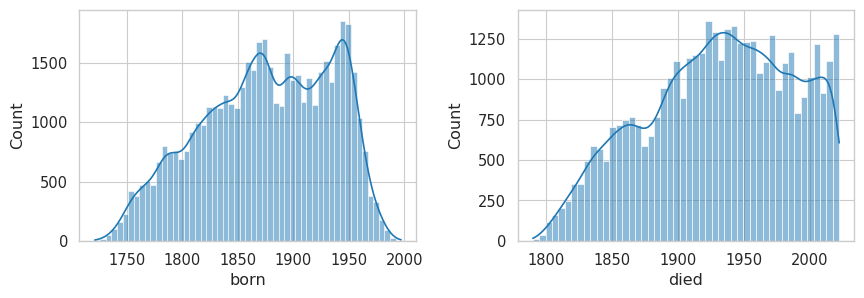

In [28]:
plot_histograms(df_charts, ['born', 'died'], 1, 2)

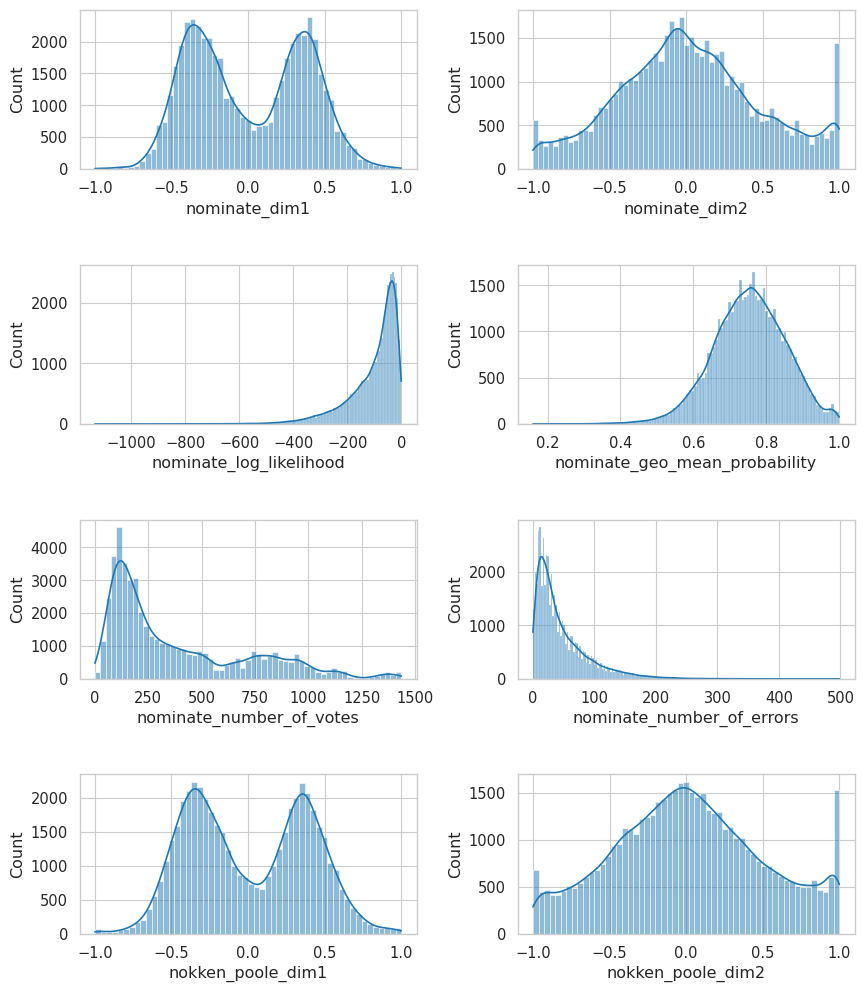

In [29]:
plot_histograms(df_charts, [
    'nominate_dim1', 'nominate_dim2','nominate_log_likelihood', 'nominate_geo_mean_probability', 
    'nominate_number_of_votes', 'nominate_number_of_errors', 'nokken_poole_dim1', 'nokken_poole_dim2'], 4, 2)

# Categorical EDA

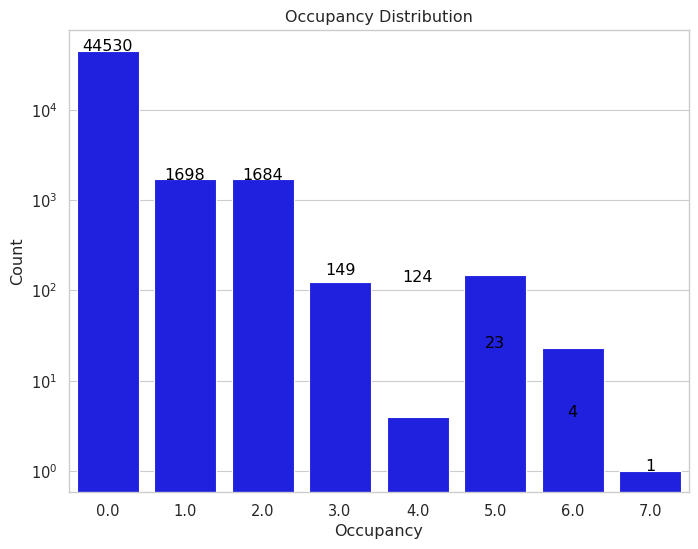

In [30]:
value_counts = pd.DataFrame(df['occupancy'].value_counts()).reset_index()

sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(x='index', y='occupancy', data=value_counts, color='blue', ax=ax)
ax.set_yscale('log')
ax.set_xlabel('Occupancy')
ax.set_ylabel('Count')
ax.set_title('Occupancy Distribution')

# Add text labels on top of the bars
for i, v in enumerate(value_counts['occupancy']):
    ax.text(i, v, str(v), color='black', ha='center')

plt.show()

# Partial details functions

In [31]:
def get_partial_df_for_column_with_nan(df, col_name):
    ''' Extract partial dataframe where NAN values Are present for teh given column
    '''
    mask = df[col_name].isnull()
    df_op = df.loc[mask]
    
    return(df_op)

def display_partial_df_for_column_with_nan(df, col_name):
    display(get_partial_df_for_column_with_nan(df, col_name))

In [32]:
df_t = get_partial_df_for_column_with_nan(df, 'bioguide_id')
df_t['chamber'].tolist()

['President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'House',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'House',
 'President',
 'President',
 'President',
 'President',
 'House',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President',
 'President']